# Discovering Spatio-Temporal Crime Patterns Using Unsupervised Learning


*by Justin Kim and Srishti Rajpurohit*

**Dataset:** [Seattle Police Department Crime Incident Data (2008–Present)](https://data.seattle.gov/Public-Safety/SPD-Crime-Data-2008-Present/tazs-3rd5/about_data)
(Dataset downloaded on February 10, 2026 at 4:05 PM)

This notebook applies unsupervised learning methods, specifically clustering, to analyze spatial and temporal patterns in Seattle crime incident data. The analysis includes preprocessing, exploratory data analysis, and feature engineering to prepare the dataset for pattern discovery.


## 0. Setup

In [223]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

## 1. Data Overview

### 1.1 Load Data

In [224]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('data/SPD_Crime_Data__2008-Present_20260210.csv')

### 1.2 Initial Inspection

In [225]:
# Display the first few rows of the DataFrame to verify it loaded correctly
df.head()

,Report Number,Report DateTime,Offense ID,Offense Date,NIBRS Group AB,NIBRS Crime Against Category,Offense Sub Category,Shooting Type Group,Block Address,Latitude,Longitude,Beat,Precinct,Sector,Neighborhood,Reporting Area,Offense Category,NIBRS Offense Code Description,NIBRS_offense_code
0,2015-190826,2015 Jun 08 09:39:00 AM,7655587915,2015 May 24 02:00:00 PM,A,PROPERTY,LARCENY-THEFT,-,26XX BLOCK OF W MARINA PL,47.63103937,-122.391970808268,Q1,West,Q,-,7089,PROPERTY CRIME,All Other Larceny,23H
1,2008-479747,2008 Dec 28 10:14:00 PM,7639775836,2008 Dec 28 10:14:00 PM,A,PROPERTY,LARCENY-THEFT,-,-,-1.0,-1.0,D2,West,D,-,3700,PROPERTY CRIME,Theft From Motor Vehicle,23F
2,2014-158003,2014 May 20 05:42:00 PM,7668842409,2014 May 20 05:42:00 PM,A,PROPERTY,LARCENY-THEFT,-,-,-1.0,-1.0,F3,Southwest,F,-,4197,PROPERTY CRIME,All Other Larceny,23H
3,2012-380870,2012 Nov 06 09:40:00 AM,7649760707,2012 Nov 04 08:00:00 PM,A,PROPERTY,BURGLARY,-,30XX BLOCK OF 29TH AVE W,47.64773751,-122.394242455682,Q1,West,Q,-,7024,PROPERTY CRIME,Burglary/Breaking & Entering,220
4,2014-041879,2014 Feb 07 10:47:00 PM,7628705100,2014 Feb 07 09:00:00 PM,A,PROPERTY,LARCENY-THEFT,-,7XX BLOCK OF S DEARBORN ST,47.59583224,-122.323111156883,K3,West,K,-,1502,PROPERTY CRIME,Theft From Motor Vehicle,23F


In [226]:
# Display the column names to understand the structure of the dataset
df.columns

Index(['Report Number', 'Report DateTime', 'Offense ID', 'Offense Date',
       'NIBRS Group AB', 'NIBRS Crime Against Category',
       'Offense Sub Category', 'Shooting Type Group', 'Block Address',
       'Latitude', 'Longitude', 'Beat', 'Precinct', 'Sector', 'Neighborhood',
       'Reporting Area', 'Offense Category', 'NIBRS Offense Code Description',
       'NIBRS_offense_code'],
      dtype='object')

In [227]:
# Display shape of the DataFrame to understand how many rows and columns it contains
df.shape

(1514383, 19)

In [228]:
# Display summary statistics of the DataFrame to understand the distribution of numerical columns
df.describe()

,Offense ID
count,1.514383e+06
mean,1.903475e+10
std,1.899956e+10
min,7.624429e+09
25%,7.659382e+09
50%,7.689669e+09
75%,2.640175e+10
max,6.849260e+10


In [229]:
# Display information about the DataFrame to understand data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514383 entries, 0 to 1514382
Data columns (total 19 columns):
 #   Column                          Non-Null Count    Dtype 
---  ------                          --------------    ----- 
 0   Report Number                   1514383 non-null  object
 1   Report DateTime                 1514383 non-null  object
 2   Offense ID                      1514383 non-null  int64 
 3   Offense Date                    1514383 non-null  object
 4   NIBRS Group AB                  1514383 non-null  object
 5   NIBRS Crime Against Category    1514383 non-null  object
 6   Offense Sub Category            1514383 non-null  object
 7   Shooting Type Group             1514383 non-null  object
 8   Block Address                   1514383 non-null  object
 9   Latitude                        1514383 non-null  object
 10  Longitude                       1514383 non-null  object
 11  Beat                            1514383 non-null  object
 12  Precinct      

**1.2.1 Structural Summary of the Dataset**

The dataset contains 1,514,383 crime incident records and 19 variables, representing reported crime events in Seattle over multiple years. With a memory footprint of approximately 219 MB, the dataset is sufficiently large to support meaningful exploratory and clustering analysis.

**Data Composition**

Each row corresponds to a single reported crime incident. The dataset can be grouped into the following structural components:

- **Identifier variables:** `Report Number` and `Offense ID` function as unique identifiers and do not provide analytical value for modeling.

- **Temporal variables:** `Report DateTime` and `Offense Date` capture when the incident occurred and was reported. Both are currently stored as object types and must be converted to datetime format for temporal feature extraction (e.g., `year`, `month`, `hour`, `day_of_week`).

- **Spatial variables:** `Latitude`, `Longitude`, `Precinct`, `Sector`, `Beat`, `Neighborhood`, and `Reporting Area` provide geographic information. `Latitude` and `Longitude` are stored as object types and contain placeholder values such as `-1.0`, indicating invalid or missing coordinates that must be addressed prior to spatial analysis.

- **Crime classification variables:** `Offense Category`, `Offense Sub Category`, `NIBRS Crime Against Category`, `NIBRS Offense Code Description`, and `NIBRS_offense_code` describe the nature of the offense at varying levels of granularity, enabling hierarchical analysis of crime types.

**Data Type Characteristics**

The dataset is predominantly categorical, with 18 object-type variables and only one numeric identifier column (`Offense ID`). This structure implies that substantial feature transformation and encoding will be required prior to applying clustering algorithms.

**Data Quality Considerations**

Although no explicit null values are present, placeholder values such as -1.0 in geographic coordinates and "-" in categorical fields indicate implicit missing data. These values must be identified and handled during preprocessing to ensure accurate analysis.

## 2. Data Preprocessing

### 2.1 Missing & Invalid Values

**2.1.1 Implicit Missing Values – Geographic Coordinates**


In [230]:
# Confirm the percentage of missing values in each column (should be 0 based on the info() output)
(df.isna().sum() / len(df)) * 100

Report Number                     0.0
Report DateTime                   0.0
Offense ID                        0.0
Offense Date                      0.0
NIBRS Group AB                    0.0
NIBRS Crime Against Category      0.0
Offense Sub Category              0.0
Shooting Type Group               0.0
Block Address                     0.0
Latitude                          0.0
Longitude                         0.0
Beat                              0.0
Precinct                          0.0
Sector                            0.0
Neighborhood                      0.0
Reporting Area                    0.0
Offense Category                  0.0
NIBRS Offense Code Description    0.0
NIBRS_offense_code                0.0
dtype: float64

In [231]:
# Convert 'Latitude' and 'Longitude' columns to numeric, coercing errors to NaN
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Check for invalid coordinates (Latitude or Longitude equal to -1.0)
invalid_coords = ((df['Latitude'] == -1.0) | (df['Longitude'] == -1.0))
invalid_coords.sum()


np.int64(171772)

In [232]:
# Calculate the percentage of invalid coordinates in the dataset
invalid_coords.sum() / len(df) * 100

np.float64(11.34270524695536)

Although no explicit null values were detected, inspection of the geographic fields revealed placeholder values of -1.0 in the Latitude and Longitude columns. These values represent invalid or missing spatial information.

After converting both columns to numeric format, 172,314 records were identified as containing invalid coordinates, representing approximately 11.34% of the dataset.

Because spatial clustering requires valid geographic information, these records cannot meaningfully contribute to spatial pattern discovery.

In [233]:
# Drop records lacking valid coordinates
df = df[~invalid_coords].copy()

# Check shape of the DataFrame after dropping invalid coordinates
df.shape

(1342611, 19)

To ensure meaningful spatial analysis, all records with invalid geographic coordinates were removed from the dataset.

This preprocessing step reduces noise and prevents distortion in subsequent clustering analysis, as incidents lacking valid latitude and longitude values cannot be assigned to spatial clusters.

The dataset now consists exclusively of incidents with valid spatial information (1,342,611 records).

**2.1.2 Geographic Boundary Validation**

In [234]:
# Calculate the percentage of records with Latitude outside the expected range for Seattle (47 to 48 degrees)
invalid_geo = ((df['Latitude'] < 47) | (df['Latitude'] > 48)) | ((df['Longitude'] < -123) | (df['Longitude'] > -122))
invalid_geo.sum() / len(df) * 100

np.float64(0.04059254691046029)

In [235]:
df = df[~invalid_geo].copy()

In addition to placeholder values (-1.0), a small number of records contained geographic coordinates outside realistic Seattle bounds. A bounding box was defined based on Seattle’s approximate latitude and longitude range.

A total of 542 records (approximately 0.04%) were identified as having coordinates outside these bounds and were removed. These values likely represent data entry or geocoding errors.

Removing these records ensures that subsequent spatial analysis is restricted to valid geographic locations within Seattle.

**2.1.3 Implicit Missing Values - Categorical Geographic Fields**

In [236]:
# Check for invalid Categorical Geographic Data (e.g., "Neighborhood", "Beat", "Precinct", "Sector") represented as "-"
geo_cat_cols = ["Neighborhood", "Beat", "Precinct", "Sector"]

dash_counts = {col: (df[col] == "-").sum() for col in geo_cat_cols}
dash_pct = {col: (df[col] == "-").mean() * 100 for col in geo_cat_cols}

summary = pd.DataFrame({
    "dash_count": [dash_counts[c] for c in geo_cat_cols],
    "dash_pct": [dash_pct[c] for c in geo_cat_cols],
}, index=geo_cat_cols)

summary

,dash_count,dash_pct
Neighborhood,575002,42.844540
Beat,2840,0.211614
Precinct,2329,0.173538
Sector,2834,0.211167


Inspection of categorical geographic fields revealed the presence of placeholder values ("-") representing implicit missing data. 

Approximately 42.8% of records lack an assigned `Neighborhood`, while missing values in `Beat`, `Precinct`, and `Sector` account for less than 1% of records. These placeholder values must be addressed to ensure accurate aggregation and grouping during exploratory analysis.

In [237]:
# Replace "-" with NaN in the geographic categorical columns
df[geo_cat_cols] = df[geo_cat_cols].replace("-", np.nan)

# Verify that the replacement was successful by checking the counts of "-" again
dash_counts_after = {col: (df[col] == "-").sum() for col in geo_cat_cols}
dash_counts_after

{'Neighborhood': np.int64(0),
 'Beat': np.int64(0),
 'Precinct': np.int64(0),
 'Sector': np.int64(0)}

The placeholder values ("-") were replaced with NaN to ensure proper handling of missing data within pandas operations. 

All affected columns were verified to confirm successful replacement. Records were retained because geographic coordinates (Latitude and Longitude) remain available for spatial analysis even when categorical geographic labels are missing.

### 2.2 Type Conversion

In [238]:
# Define the expected date format for 'Report DateTime' and 'Offense Date' columns
fmt = "%Y %b %d %I:%M:%S %p"   # e.g., 2015 Jun 08 09:39:00 AM

# Convert 'Report DateTime' and 'Offense Date' columns to datetime, coercing errors to NaT
df["Report DateTime"] = pd.to_datetime(df["Report DateTime"], format=fmt, errors="coerce")
df["Offense Date"] = pd.to_datetime(df["Offense Date"], format=fmt, errors="coerce")

# Check for any remaining missing values in the 'Report DateTime' and 'Offense Date' columns after conversion
df[["Report DateTime", "Offense Date"]].isna().sum()

Report DateTime    0
Offense Date       0
dtype: int64

The Report DateTime and Offense Date columns were originally stored as string (object) types. These variables were converted to datetime format using an explicit format specification to ensure accurate temporal parsing and avoid inference errors. No malformed timestamps were detected during conversion.

### 2.3 Cleaning & Filtering

**2.3.1 Temporal Boundary Enforcement**

In [239]:
df["Offense Date"].dt.year.describe()

count    1.342066e+06
mean     2.017126e+03
std      5.157364e+00
min      1.900000e+03
25%      2.013000e+03
50%      2.018000e+03
75%      2.022000e+03
max      2.026000e+03
Name: Offense Date, dtype: float64

In [240]:
# Count the number of records with 'Offense Date' before 2008
(df["Offense Date"].dt.year < 2008).sum()

np.int64(2205)

Although datetime conversion was successful, inspection of the offense year distribution revealed the presence of records prior to the documented dataset start year (2008). A total of 2,205 records were identified with offense dates before 2008. To ensure temporal consistency with the dataset scope, these records were removed.

**2.3.2 Identifier Column Removal**

In [241]:
df = df.drop(columns=["Report Number", "Offense ID"])

Identifier columns were removed as they do not contain analytical signal and are unsuitable for modeling or clustering purposes.


**2.3.3 Removal of High-Granularity Address Field**

In [242]:
df["Block Address"].nunique()

36091

In [243]:
df = df.drop(columns=["Block Address"])

The `Block Address` column provides street-level textual descriptions of incident locations and contains approximately 3,601 unique values. While this level of detail may be useful in street-specific investigations, it introduces unnecessary granularity for the purposes of clustering analysis.

The dataset already includes structured geographic variables such as `Neighborhood`, `Precinct`, `Sector`, and `Beat`, which provide meaningful categorical representations of location. In addition, precise spatial coordinates (`Latitude` and `Longitude`) are available for continuous spatial analysis.

Because the block-level address information is both redundant and difficult to encode meaningfully for distance-based clustering algorithms, it was removed to reduce dimensionality and maintain a clean feature space.

**2.3.4 Removal of Non-Criminal Records**

In [266]:
df["Offense Category"].value_counts()

Offense Category
ALL OTHER         624196
PROPERTY CRIME    595001
VIOLENT CRIME      75444
Name: count, dtype: int64

In [244]:
df["Offense Sub Category"].value_counts()

Offense Sub Category
LARCENY-THEFT                                            401111
ALL OTHER                                                165816
ASSAULT OFFENSES                                         129158
BURGLARY                                                 115024
PROPERTY OFFENSES (INCLUDES STOLEN, DESTRUCTION)         108135
MOTOR VEHICLE THEFT                                       76763
EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD CHECKS)     70454
999                                                       47383
AGGRAVATED ASSAULT                                        43030
TRESPASS                                                  37101
NARCOTIC VIOLATIONS (INCLUDES DRUG EQUIP.)                28823
ROBBERY                                                   26712
VIOLATION OF NO CONTACT ORDER                             23532
DUI                                                       19219
NON-VIOLENT FAMILY OFFENSES                               11910
WEAPON LAW VIOLATIO

In [245]:
df["NIBRS Crime Against Category"].value_counts(dropna=False)

NIBRS Crime Against Category
PROPERTY       800302
PERSON         207707
ANY            165816
SOCIETY        119456
NOT_A_CRIME     47425
-                1360
Name: count, dtype: int64

In [246]:
# Check for invalid values in "NIBRS Crime Against Category" column represented as "-"
(df["NIBRS Crime Against Category"] == "-").sum()

np.int64(1360)

In [247]:
# Remove records with "Offense Sub Category" equal to "999"
df = df[df["Offense Sub Category"] != "999"].copy()

# Replace "UNKNOWN" with NaN in "Offense Sub Category" column
df["Offense Sub Category"] = df["Offense Sub Category"].replace("UNKNOWN", np.nan)

# Replace "-" with NaN in "NIBRS Crime Against Category" column
df["NIBRS Crime Against Category"] = df["NIBRS Crime Against Category"].replace("-", np.nan)

# Remove records with "NIBRS Crime Against Category" equal to "NOT_A_CRIME"
df = df[df["NIBRS Crime Against Category"] != "NOT_A_CRIME"].copy()


During category-level inspection, records labeled with `Offense Sub Category = 999` were identified as administrative entries classified as "Not Reportable to NIBRS." These records do not represent actual crime events and were removed from the dataset.

Additionally, placeholder values represented by `"-"` or `UNKNOWN` in categorical fields were converted to `NaN` to ensure proper handling of missing data.

A small number of remaining records labeled as `NOT_A_CRIME` under `NIBRS Crime Against Category` were also removed to maintain analytical consistency.

After these cleaning steps, the dataset contains only valid crime incidents suitable for spatial, temporal, and clustering analysis.

## 3. Exploratory Data Analysis

### 3.1 Temporal Patterns

### 3.2 Spatial Patterns

**3.2.1 Crime Count by Neighborhood**

In [248]:
# Drop missing values in the 'Neighborhood' column
neighborhood_counts = (
    df["Neighborhood"]
    .dropna()
    .value_counts()
)

neighborhood_counts.head(15)

Neighborhood
DOWNTOWN COMMERCIAL                 50314
CAPITOL HILL                        47218
NORTHGATE                           40413
QUEEN ANNE                          37872
SLU/CASCADE                         32770
UNIVERSITY                          29643
ROOSEVELT/RAVENNA                   27362
BALLARD SOUTH                       26345
FIRST HILL                          24780
CHINATOWN/INTERNATIONAL DISTRICT    21370
LAKECITY                            19368
CENTRAL AREA/SQUIRE PARK            18685
BELLTOWN                            17841
SANDPOINT                           16108
GREENWOOD                           14898
Name: count, dtype: int64

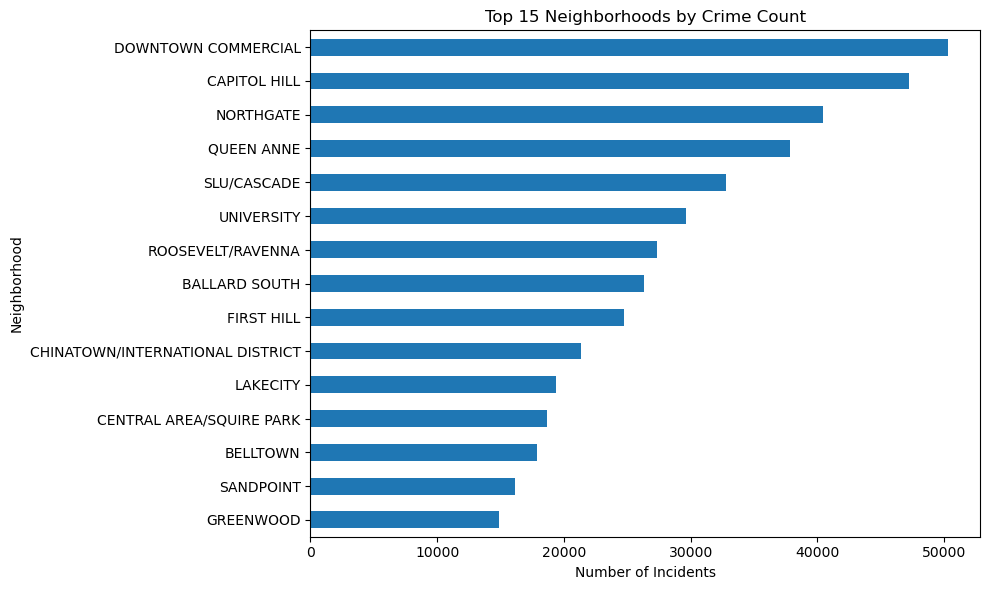

In [249]:

# Visualize the top 15 neighborhoods by crime count
top_15 = neighborhood_counts.head(15)
plt.figure(figsize=(10, 6))
top_15.sort_values().plot(kind="barh")
plt.xlabel("Number of Incidents")
plt.ylabel("Neighborhood")
plt.title("Top 15 Neighborhoods by Crime Count")
plt.tight_layout()
plt.show()

Crime incidents are highly concentrated in central and mixed-use neighborhoods. Downtown Commercial exhibits the highest number of reported incidents, followed closely by Capitol Hill and Northgate. 

This pattern suggests spatial clustering in high-density commercial and entertainment areas, where population flow and activity levels are elevated. Peripheral and predominantly residential neighborhoods show comparatively lower incident frequencies.

**3.2.2 Crime Count by Precinct**

In [250]:
# Drop missing values in the 'Precinct' column
precinct_counts = (
    df["Precinct"]
    .dropna()
    .value_counts()
)

precinct_counts

Precinct
North        396358
West         368577
East         216665
South        185216
Southwest    123374
OOJ            2215
Name: count, dtype: int64

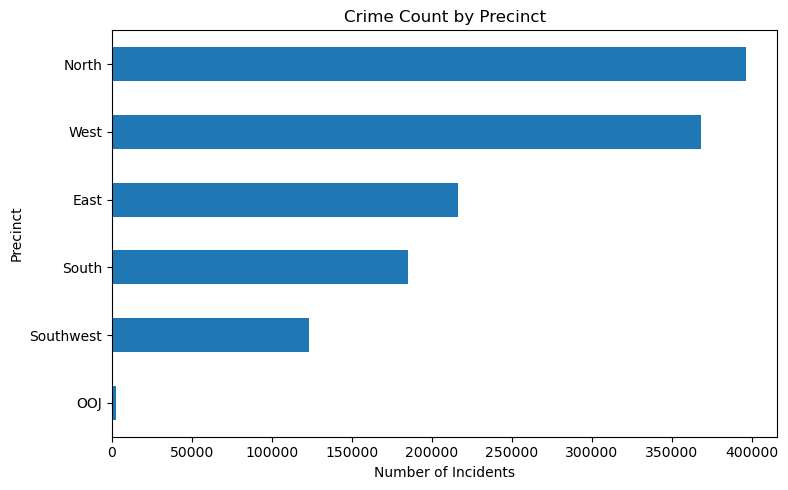

In [251]:
# Visualize crime count by precinct
plt.figure(figsize=(8, 5))
precinct_counts.sort_values().plot(kind="barh")
plt.xlabel("Number of Incidents")
plt.ylabel("Precinct")
plt.title("Crime Count by Precinct")
plt.tight_layout()
plt.show()

Crime distribution across precincts is uneven, with the North and West precincts reporting the highest number of incidents. These precincts encompass central and high-density areas of the city, which likely contributes to elevated crime frequency.

The East and South precincts exhibit moderate incident counts, while the Southwest precinct reports comparatively fewer incidents. The "OOJ" category represents a minimal number of cases and likely corresponds to administrative or out-of-jurisdiction records rather than a physical patrol area.

Overall, the results reinforce the presence of spatial clustering at a broader administrative level, consistent with the neighborhood-level patterns observed earlier.

**3.1.3 Spatial Density Using Geographical Coordinates**

In [252]:
# Create a sample of the data for spatial visualization 
sample_size = 200000
df_sample = df.dropna(subset=["Latitude", "Longitude"]).sample(
    n=sample_size, random_state=42
)

len(df_sample)

200000

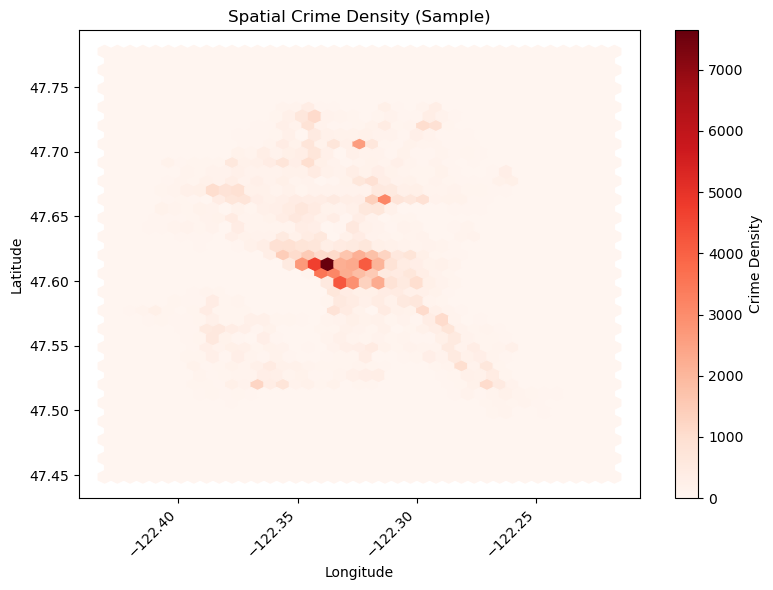

In [253]:
# Visualize spatial crime density using a hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(
    df_sample["Longitude"],
    df_sample["Latitude"],
    gridsize=40,
    cmap="Reds"
)
plt.colorbar(label="Crime Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Crime Density (Sample)")
plt.xticks(rotation=45, ha="right")   # Rotate x-axis labels
plt.tight_layout()
plt.show()

The spatial density visualization using a reduced grid size (gridsize=40) provides a clearer view of geographic concentration patterns. Crime incidents are visibly clustered in central areas of the city, with density decreasing toward peripheral regions.

Increasing the sample size to 200,000 observations did not materially alter the observed spatial structure, indicating that the clustering pattern is stable and not an artifact of sampling variation.

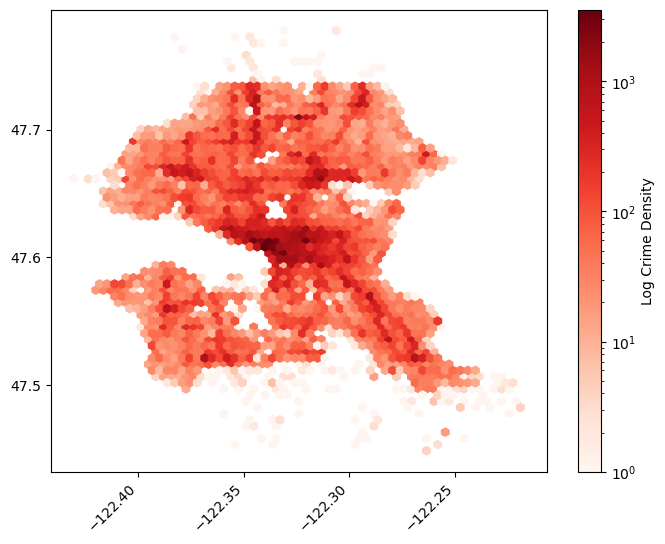

In [270]:
# Visualize spatial crime density using a hexbin plot with logarithmic color scaling
plt.figure(figsize=(8, 6))
plt.hexbin(
    df_sample["Longitude"],
    df_sample["Latitude"],
    gridsize=60,
    bins="log",
    cmap="Reds"
)

plt.xticks(rotation=45, ha="right")
plt.locator_params(axis="x", nbins=6)
plt.locator_params(axis="y", nbins=6)
plt.colorbar(label="Log Crime Density")

The log-scaled density visualization provides a clearer representation of spatial distribution by reducing the dominance of extreme hotspot values. While downtown remains the highest-density region, additional mid-density clusters become visible throughout adjacent neighborhoods.

This confirms that crime concentration follows a central-core pattern, with multiple secondary clusters radiating outward rather than a single isolated hotspot.

### 3.3 Crime Category Analysis

In [ ]:
# Unique value counts for crime category columns
crime_cat_cols = [
    "Offense Category",
    "Offense Sub Category",
    "NIBRS Crime Against Category"
]

cardinality_summary = pd.DataFrame({
    "Unique Values": [df[col].nunique() for col in crime_cat_cols]
}, index=crime_cat_cols)

cardinality_summary

,Unique Values
Offense Category,3
Offense Sub Category,27
NIBRS Crime Against Category,4


**3.3.1 Broad Offense Category Distribution**

In [ ]:
# Distribution of "Offense Category"
crime_cat_counts = df["Offense Category"].value_counts()

crime_cat_counts

Offense Category
ALL OTHER         624196
PROPERTY CRIME    595001
VIOLENT CRIME      75444
Name: count, dtype: int64

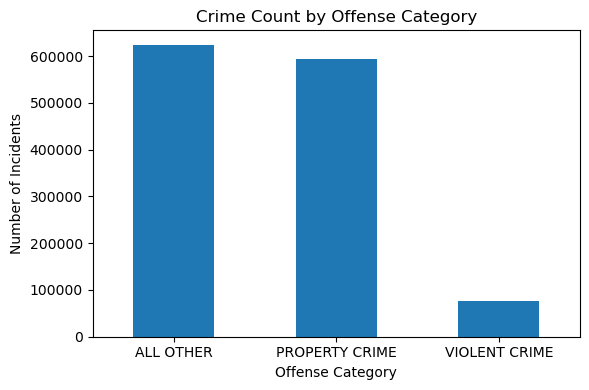

In [ ]:
# Visualize crime count by offense category
plt.figure(figsize=(6,4))
crime_cat_counts.plot(kind="bar")
plt.ylabel("Number of Incidents")
plt.title("Crime Count by Offense Category")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The dataset is heavily concentrated in two broad categories: `ALL OTHER` and `PROPERTY CRIME`, which together account for the vast majority of reported incidents. `VIOLENT CRIME` represents a substantially smaller portion of total offenses.

This imbalance indicates that crime incidents are not uniformly distributed across high-level classifications. The dominance of non-violent and property-related offenses suggests that clustering results may be influenced primarily by these categories unless additional granularity is introduced.

Because broad categories exhibit limited variability (only three groups), more detailed classification through `Offense Sub Category` is necessary to capture meaningful differentiation in crime patterns.

**3.3.2 NIBRS Crime Against Category Distribution**

In [269]:
# Distribution of "NIBRS Crime Against Category"
nibrs_counts = df["NIBRS Crime Against Category"].value_counts()

nibrs_counts

NIBRS Crime Against Category
PROPERTY    800302
PERSON      207707
ANY         165816
SOCIETY     119456
Name: count, dtype: int64

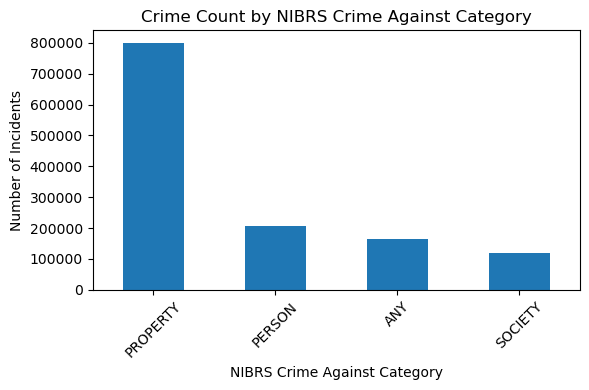

In [268]:
# Visualize crime count by NIBRS Crime Against Category
plt.figure(figsize=(6,4))
nibrs_counts.plot(kind="bar")
plt.ylabel("Number of Incidents")
plt.title("Crime Count by NIBRS Crime Against Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The `NIBRS Crime Against Category` distribution shows a strong dominance of `PROPERTY` crimes, which account for the majority of reported incidents. `PERSON` and `SOCIETY` crimes occur at substantially lower frequencies, while `ANY` represents a smaller portion of records.

This imbalance indicates that crime incidents are not evenly distributed across high-level classifications. The dominance of property-related offenses suggests that spatial and temporal clustering patterns may be heavily influenced by this category.

Although this variable provides useful high-level structure, it represents a broader abstraction of `Offense Sub Category`. Therefore, the more granular subcategory variable was selected for encoding in subsequent feature engineering.

**3.3.3 Crime Subcategory Distribution**

In [267]:
# Distribution of "Offense Sub Category"
subcat_counts = df["Offense Sub Category"].value_counts()

subcat_counts.head(15)

Offense Sub Category
LARCENY-THEFT                                            401111
ALL OTHER                                                165816
ASSAULT OFFENSES                                         129158
BURGLARY                                                 115024
PROPERTY OFFENSES (INCLUDES STOLEN, DESTRUCTION)         108135
MOTOR VEHICLE THEFT                                       76763
EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD CHECKS)     70454
AGGRAVATED ASSAULT                                        43030
TRESPASS                                                  37101
NARCOTIC VIOLATIONS (INCLUDES DRUG EQUIP.)                28823
ROBBERY                                                   26712
VIOLATION OF NO CONTACT ORDER                             23532
DUI                                                       19219
NON-VIOLENT FAMILY OFFENSES                               11910
WEAPON LAW VIOLATION                                      11628
Name: count, dtype:

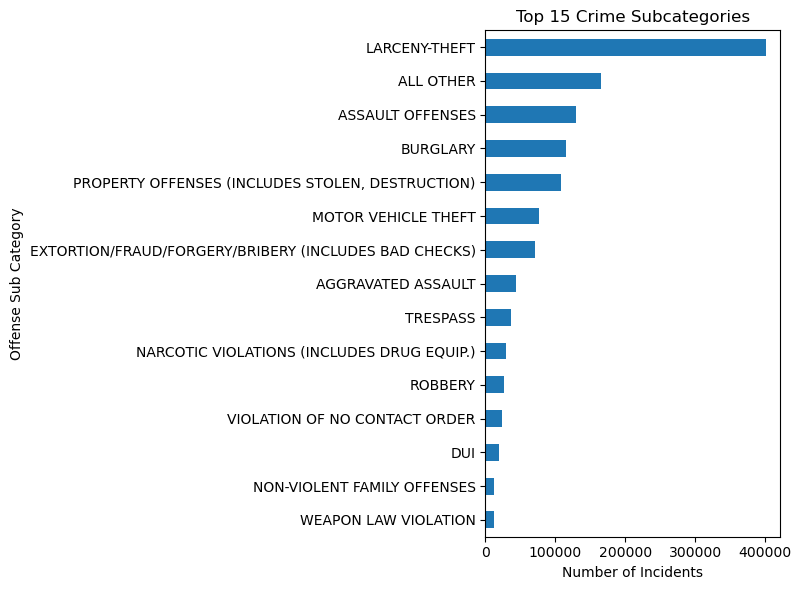

In [ ]:
# Visualize the top 15 offense subcategories by crime count
plt.figure(figsize=(8,6))
subcat_counts.head(15).sort_values().plot(kind="barh")
plt.xlabel("Number of Incidents")
plt.title("Top 15 Crime Subcategories")
plt.tight_layout()
plt.show()

Subcategory-level analysis reveals substantial imbalance across offense types. `LARCENY-THEFT` overwhelmingly dominates the dataset, followed by categories such as `ALL OTHER`, `ASSAULT OFFENSES`, and `BURGLARY`.

A small number of subcategories account for a disproportionately large share of total incidents, while many others occur relatively infrequently. This imbalance is important for clustering, as dominant categories may heavily influence cluster formation.

Despite the skewed distribution, `Offense Sub Category` provides significantly more granular differentiation than broad offense categories and is therefore better suited for encoding and clustering analysis.

## 4. Feature Engineering

### 4.1 Temporal Features

In [262]:
# Extract temporal features from 'Offense Date'
df["Year"] = df["Offense Date"].dt.year
df["Month"] = df["Offense Date"].dt.month
df["DayOfWeek"] = df["Offense Date"].dt.dayofweek
df["Hour"] = df["Offense Date"].dt.hour

# Create a binary feature indicating whether the offense occurred on a weekend (Saturday=5, Sunday=6)
df["Is_Weekend"] = df["DayOfWeek"].isin([5, 6]).astype(int)

Temporal features were extracted from the `Offense Date` variable to capture potential seasonal and time-based crime patterns.

The following features were created:

- **Year** – Enables temporal filtering and trend analysis.
- **Month** – Captures seasonal variation in crime.
- **DayOfWeek** – Identifies weekday vs. weekend patterns.
- **Hour** – Captures time-of-day effects.
- **Is_Weekend** – Binary indicator (1 = Saturday/Sunday, 0 = Weekday) to simplify weekend pattern analysis.

These engineered features will allow clustering methods to detect temporal structure without relying on raw datetime values.

### 4.2 Spatial Features

Spatial information is represented using precise geographic coordinates (`Latitude` and `Longitude`). Because these coordinates already provide continuous spatial representation, no additional transformation was required at this stage.

These variables will be retained for clustering to capture geographic proximity and spatial structure within the dataset.

### 4.3 Encoding

In [263]:
# One-hot encode the 'Offense Sub Category' column
encoder = OneHotEncoder(drop="first", sparse_output=False)

encoded_subcat = encoder.fit_transform(
    df[["Offense Sub Category"]]
)

encoded_cols = encoder.get_feature_names_out(["Offense Sub Category"])

df_subcat_encoded = pd.DataFrame(
    encoded_subcat,
    columns=encoded_cols,
    index=df.index
)

# Concatenate the original DataFrame with the encoded columns, dropping the original 'Offense Sub Category' column
df_encoded = pd.concat(
    [df.drop(columns=["Offense Sub Category"]), df_subcat_encoded],
    axis=1
)

As observed in Section 3.3, `Offense Sub Category` contains 31 unique values and provides greater granularity compared to broader classifications. Therefore, it was selected for encoding.

The `Offense Sub Category` variable was encoded using `OneHotEncoder` from `sklearn.preprocessing` to ensure compatibility with future modeling pipelines. 

Using sklearn's encoder provides structured transformation logic and facilitates seamless integration with scaling and clustering algorithms in subsequent milestones. The first category was dropped to reduce redundant dummy representation.

### 4.4 Feature Selection Rationale

For clustering purposes, a subset of engineered features was selected to balance interpretability and dimensionality.

Selected features include:

- `Latitude` and `Longitude` to capture spatial proximity.
- `Month`, `DayOfWeek`, `Hour`, and `Is_Weekend` to represent temporal structure.
- `Offense Sub Category` to provide granular crime-type differentiation.

Broad crime classifications were excluded to avoid redundancy with subcategories. Administrative geographic labels (`Neighborhood`, `Precinct`, `Beat`, `Sector`) were excluded to prevent artificial boundary effects in distance-based clustering.

Identifier fields and raw datetime values were also excluded.